In [2]:
"""

Date: 25 Dec 2019

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

Training test whether the threshold is changing
    •  Implementation with sigmoid wrapped in a FlexiLayer class on FMNIST dataset
    •  Visualising threshold over the training process
This is baseline, accuracy: 87.6%

"""

# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

#set size of batch and learning rate
batch_size=4
lr=0.001

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        self.threshold1 = nn.parameter.Parameter(torch.randn((4, 6, 24, 24)), requires_grad=True)
        self.memorized = self.threshold1.clone()
        self.memorized_1loop = []
            
    def forward(self, t):
        
        t_1 = F.relu(F.conv2d(t, self.weight)) # get convolution result
        t_2 = F.max_pool2d(t, kernel_size=5, stride=1) # get max result with the same kernel size
        m = nn.Sigmoid()
        condmax = torch.sub(t_2, self.threshold1)
        condconv = torch.sub(t_2, self.threshold1)
        t_2 = m(condmax*50)*t_2 # 
        t_1 = m(condconv*(-50))*t_1 # 
        t = torch.add(t_2, t_1)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        return t

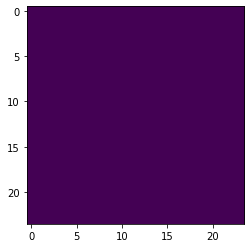

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flex1 = FlexiLayer(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (2) Flexible layer
        t = self.flex1(t)
        
        # (3) hidden conv layer
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()
memorized = net.flex1.memorized
#before training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

-4.0465455
-4.0465455


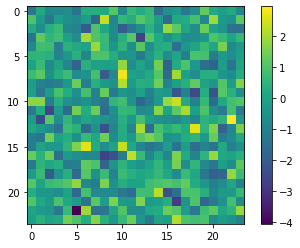

In [35]:
#before training
imgplot = plt.imshow(memorized.detach().numpy()[1,1,:])
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar()
print(np.min(memorized.detach().numpy()[1,1,:]))
print(memorized.detach().numpy()[1,1,22,5])

In [53]:
test = torch.empty(4, 6, 24, 24).normal_(mean=0.5,std=0.1)
print(np.min(test.detach().numpy()[1,1,:]))
print(np.max(test.detach().numpy()[1,1,:]))

0.12150921
0.7736935


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [5]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

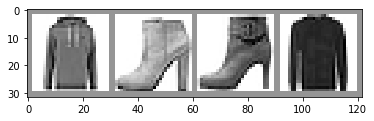

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
#writer.add_image('four_fake_images', img_grid)

In [7]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(comment=f'4_Threshold_testing3-Copy3  batch_size={batch_size} lr={lr}')

epoch: 0 loss: 47375.58913008741
epoch: 1 loss: 28424.255176582665
epoch: 2 loss: 25261.889718442282
epoch: 3 loss: 23305.80308387142
epoch: 4 loss: 22135.76101103519
epoch: 5 loss: 21236.306678757624
epoch: 6 loss: 20542.686888113174
epoch: 7 loss: 19800.507267739133
epoch: 8 loss: 19558.449369760685
Finished Training


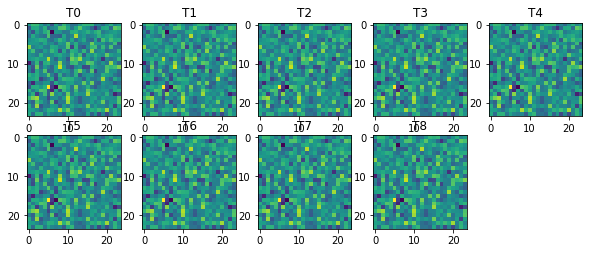

In [8]:
running_loss = 0.0
plt.figure(figsize=(10,10))
for epoch in range(9):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0
    
    nsamples = 1000

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)
        
        if i == 1:
            net.flex1.memorized_1loop = net.flex1.threshold1
        
    # ...log the total epoch accuracy
    writer.add_scalar('Accuracy', total_correct / len(trainset), epoch)
            
    print("epoch:", epoch, "loss:", total_loss)
    # every epoch plot threshold
    title = 'T'+str(epoch)
    plt.subplot(5,5, epoch + 1)
    plt.subplots_adjust(hspace=0.4, bottom=0.2)
    plt.title(title)
    imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:])
        
print('Finished Training')

In [9]:
print(total_correct / len(trainset))

0.8764166666666666


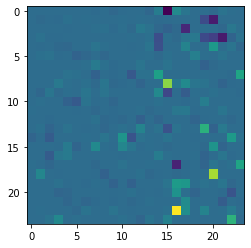

In [10]:
#after training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

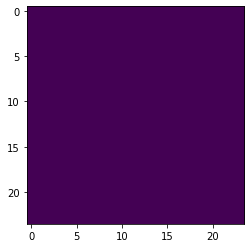

In [11]:
#after training single training loop
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - net.flex1.memorized_1loop.detach().numpy()[1,1,:])

C:\Users\User\Anaconda3\envs\meng\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

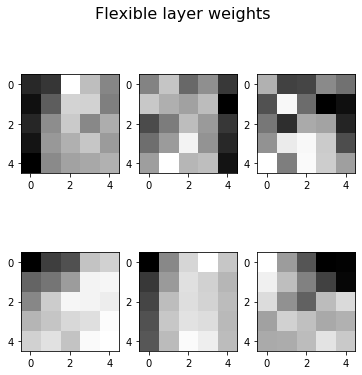

In [12]:
# plot the flexilayer weights

fig = plt.figure()
plt.figure(figsize=(6,6))
plt.suptitle('Flexible layer weights', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(2,3, idx + 1)
    plt.imshow(net.flex1.weight.detach().numpy()[idx,0,:,:], cmap="gray")

    
fig.show()

C:\Users\User\Anaconda3\envs\meng\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

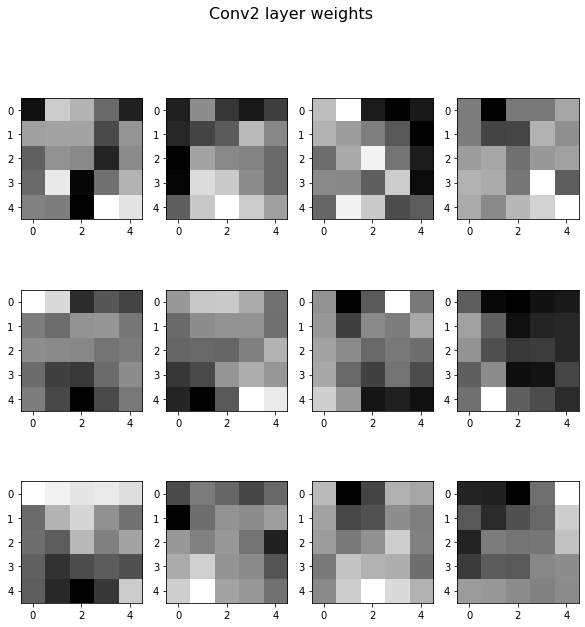

In [13]:
# plot the conv2 weights

fig = plt.figure()
plt.figure(figsize=(10,10))
plt.suptitle('Conv2 layer weights', fontsize = 16)
for idx, filt  in enumerate(net.conv2.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(3,4, idx + 1)
    plt.imshow(net.conv2.weight.detach().numpy()[idx,0,:,:], cmap="gray")
    
fig.show()